# Tanzania Water Pump- Exploratory Data Analysis (EDA)

---



Predict whether a pump is functional, functional needing repair, or non-functional using data from [Taarifa](http://taarifa.org/) and [Tanzania Ministry of Water](http://maji.go.tz/) based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A proper understanding of which water pumps are likely to fail could optimize maintenance operations and more reliably provide Tanzanian citizens with potable water.

This predictive modeling challenge comes from [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), an organization that helps non-profits by hosting data science competitions for social impact. A description of the features in this dataset can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list). The competition has open licensing: "The data is available for use outside of DrivenData." The data was provided for a private Kaggle competition held as part of BloomTech's Data Science curriculum.

### Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier


### Load and Explore Data

In [2]:
# Load .csv files as pandas dataframes, combining training features and target
df = pd.merge(pd.read_csv('train_features.csv').set_index('id'),
              pd.read_csv('train_labels.csv').set_index('id'),
              on='id')

X_test = pd.read_csv('test_features.csv')

In [3]:
# View shape of dataframe
print(df.shape, X_test.shape)

(47520, 40) (11880, 40)


In [4]:
# View first 5 rows of training dataframe
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


In [5]:
Report = ProfileReport(df, minimal = True).to_notebook_iframe()
Report

# Create html file of pandas profile report
# Report.to_file("raw_pandas_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From our Pandas-profiling report, we can see that:

- `’amount_tsh’` is skewed by extreme outliers such as 350,000 while the majority of the data (75%) is no higher than 20. This feature is also comprised of 70% zeros. We do not anticipate this feature to add enough value to our model to be worth keeping it.
- We have numerous high cardinality categorical features, which we will remove
- Many redundant columns, so we will remove all but one:
  - `’region’` and `’region_code’`
  - `’extraction_type’`, `’extraction_type_group’`,  and `’extraction_type_class’` 
  - `’scheme_management’` and `’management’`
  - `’payment’` and `’payment_type’` 
  - `’water_quality’` and `’quality_group’`
  - `’quantity’` and `’quantity_group’`
  - `’source’`, `’source_type’`, and `’source_type’` 
  - `’waterpoint_type’` and `’waterpoint_type_group’` 

In [6]:
# Preview info about datatypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             47520 non-null  float64
 1   date_recorded          47520 non-null  object 
 2   funder                 44644 non-null  object 
 3   gps_height             47520 non-null  int64  
 4   installer              44631 non-null  object 
 5   longitude              47520 non-null  float64
 6   latitude               47520 non-null  float64
 7   wpt_name               47520 non-null  object 
 8   num_private            47520 non-null  int64  
 9   basin                  47520 non-null  object 
 10  subvillage             47224 non-null  object 
 11  region                 47520 non-null  object 
 12  region_code            47520 non-null  int64  
 13  district_code          47520 non-null  int64  
 14  lga                    47520 non-null  object 
 15  

In [15]:
# Check number of null values per column
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2876
gps_height                   0
installer                 2889
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 296
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2689
recorded_by                  0
scheme_management         3102
scheme_name              22523
permit                    2439
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [7]:
# View basic descriptive statistics for numeric columns
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,322.047573,668.745370,34.091316,-5.705002e+00,0.504566,15.326515,5.639310,179.528283,1303.353199
std,3200.623244,692.972153,6.538403,2.943503e+00,13.253850,17.618798,9.661285,472.772997,950.763878
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.084320,-8.532465e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.911677,-5.017697e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.180585,-3.326464e+00,0.000000,17.000000,5.000000,213.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [17]:
# Number of unique values per column
df.nunique()

id                       47520
amount_tsh                  96
date_recorded              351
funder                    1698
gps_height                2401
installer                 1923
longitude                46043
latitude                 46044
wpt_name                 30742
num_private                 59
basin                        9
subvillage               17232
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2076
population                 971
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

### Data Cleaning
After initial exploration of the data, a number of necessary adjustments need to be made:
- Adjust datatypes
  - Convert `'date_recorded'` and `'construction_year'` to datetime
  - Convert `'public_meeting'` and `'permit'` to boolean
- Manage null values 
- There are a number of apparently redundant columns
- High cardinality features
- Other
  - Remove constant column 'recorded_by'
  - Plot by lat and long

#### Convert Datatypes

str

#### Manage Null Values

In [43]:
null_counts = df.isnull().sum()
null_series = null_counts[null_counts > 0]
null_series

funder                2876
installer             2889
subvillage             296
public_meeting        2689
scheme_management     3102
scheme_name          22523
permit                2439
dtype: int64

In [49]:
percent_nulls = round(null_series / len(df) * 100, 2)
percent_nulls

funder                6.05
installer             6.08
subvillage            0.62
public_meeting        5.66
scheme_management     6.53
scheme_name          47.40
permit                5.13
dtype: float64

We will remove `'scheme_name'` because almost 50% of the data is missing.

In [50]:
df.drop(columns='scheme_name', inplace=True)

#### Remove duplicate columns

#### Handle high-cardinality categorical features

#### Plot Geographic Coordinates

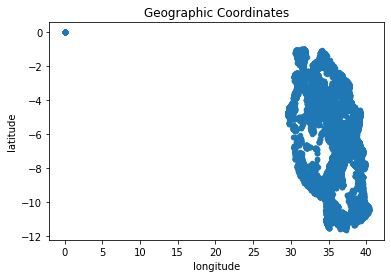

In [18]:
# View coordinate plot of water pumps
df.plot("longitude", "latitude", kind="scatter")
plt.title("Geographic Coordinates");

There appear to be null values that were recorded as (0, 0), but we will check their values before dropping them from our plot

In [19]:
print(f"""Minimum longitude: {df['longitude'].min()},
    Maximum latitude: {df['latitude'].max()}""")

Minimum longitude: 0.0,
    Maximum latitude: -2e-08


In [21]:
long = df["longitude"][df["longitude"] > 0]
lat = df["latitude"][df["latitude"] < df["latitude"].max()]

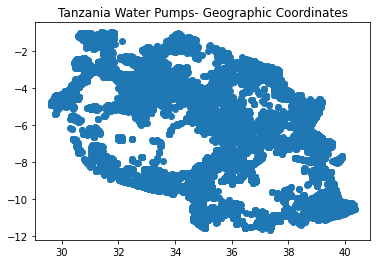

In [23]:
plt.scatter(long, lat)
plt.title("Tanzania Water Pumps- Geographic Coordinates");

#### Remove constant value column `'recorded_by'`

In [24]:
df.drop(columns='recorded_by', inplace=True)

### Feature Engineering

`'pump_age'` = `'recorded_year'` - `'construction_year'`